# Alzheimer prediction using gray matter density from T1w MRI 

**Deadline**: Upload this notebook (rename it as 'TP4-IMA205-YOUR-SURNAME.ipynb') with your answers to the Site pédagogique before the 18th of March 2020 (23h59).

Please complete the code where you see XXXXXXXXXXXX and answer the questions.

We will use a dataset composed of neuroimaging features from brain T1w MR images of 752 subjects, 416 controls and 336 with Alzheimer’s disease. Following the pipeline described in [1], all images are first normalized to a
common space, providing a voxel-wise correspondence across subjects. Then, gray matter density is computed at each voxel and averaged over a set of ROIs (Region of Interest) of an atlas, at the beginning you will use the [AAL2 atlas](http://www.gin.cnrs.fr/en/tools/aal/). Data comes from several freely available datasets, like [ADNI](http://adni.loni.usc.edu/) and [OASIS](https://www.oasis-brains.org/), and has been pre-processed by the [Clinica](http://www.clinica.run/) team using the procedure explained in [1].

Please load the data from the file: *dataTP.npz* where *T1x* is a matrix containing the averaged density (each row is a subject and each column a feature), *y* is a vector containing the diagnosis (0 for controls and 1 for Alzheimer’s patients) and *ROIlabelsx* contains the name of the ROI of each feature. Here, *x* can take the name of the three atlases you have at your disposal: AAL2, [AICHA](http://www.gin.cnrs.fr/fr/outils/aicha/), [HAMMERS](https://brain-development.org/brain-atlases/adult-brain-atlases/).

**Reference**:
[1] J. Samper-González, N. Burgos, S. Bottani, S. Fontanella, P. Lu, A. Marcoux, A. Routier, J. Guillon, M. Bacci, J. Wen, A. Bertrand, H. Bertin, M.-O. Habert, S. Durrleman, T. Evgeniou, O. Colliot. *Reproducible evaluation of classification methods in Alzheimer's disease: framework and application to MRI and PET data*. NeuroImage, 2018 

In [2]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
import warnings
warnings.filterwarnings('ignore', category=ImportWarning)
from sklearn.preprocessing import StandardScaler
import os
import numpy as np
import pandas as pd
from skimage.io import imread
from time import time
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import AxesGrid
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split
from sklearn.model_selection import  cross_val_score
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.linear_model import Perceptron
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
%matplotlib inline


# Libraries
import numpy as np
import matplotlib.pyplot as plt
!pip install -q nilearn
from nilearn import plotting
%matplotlib inline
np.random.seed(seed=666)

from google_drive_downloader import GoogleDriveDownloader as gdd
gdd.download_file_from_google_drive(file_id='11cQmPm64k3T7ml5fPLetZgb1j1AjHBH8',
dest_path='./dataTP.npz')
gdd.download_file_from_google_drive(file_id='1S7e5IrPygE4VV0JTwqJIlyO2S_NhsiI4',
dest_path='./AtlasAAL2.nii')
gdd.download_file_from_google_drive(file_id='1E0pu5jIMpgcs2DQ8lBGWliwEBZvKrnV9',
dest_path='./AtlasAICHA.nii')
gdd.download_file_from_google_drive(file_id='1yltKwULrkHYh79RAh_zAg08r8pQMjRlQ',
dest_path='./AtlasHAMMERS.nii')

with np.load('./dataTP.npz',allow_pickle=True) as data:
    T1AAL2 = data['T1AAL2'] # data from AAL2 Atlas
    T1AICHA = data['T1AICHA'] # data from AICHA Atlas
    T1HAMMERS = data['T1HAMMERS'] # data from HAMMERS Atlas  
    y = data['y'] # classes, 0 for controls and 1 for patients    
    ROIlabelsAAL2 = data['ROIlabelsAAL2'] # labels for ROIs of atlas AAL2 
    ROIlabelsAICHA = data['ROIlabelsAICHA']    # labels for ROIs of atlas AICHA 
    ROIlabelsHAMMERS = data['ROIlabelsHAMMERS']    # labels for ROIs of atlas HAMMERS 

     |████████████████████████████████| 2.5MB 2.7MB/s 


In [3]:
# Choose Atlas (here AAL2)
X=T1AAL2
labels=ROIlabelsAAL2
atlas='./AtlasAAL2.nii'

N,M = X.shape # number subjects and ROIs
class_names = ["control","alzheimer"] # y=0, y=1

print('Number of controls and Alzheimer patients is respectively: {0} and {1}'.format(N-np.sum(y), np.sum(y)))
print('Number of ROI is: {0}'.format(M))

Number of controls and Alzheimer patients is respectively: 416.0 and 336.0
Number of ROI is: 120


Using the library nilearn we can also plot the atlas used to define the ROIs:

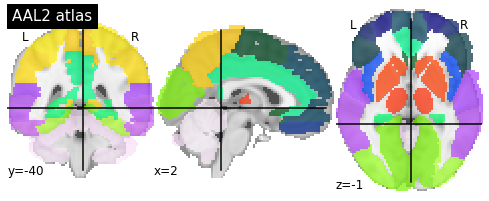

In [4]:
plotting.plot_roi(atlas, title="AAL2 atlas")
plotting.show()

In this TP we will use Decision Trees, Bagging and Random Forests. Let's start with Decision Trees. First of all, we need to scale the features so that each feature will have average equal to 0 and unit variance and create a training and test set.

In [0]:
# Scale data (each feature will have average equal to 0 and unit variance)

scaler = StandardScaler()
scaler.fit(X)
X_scale=scaler.transform(X)

# Create training and test set
X_train, X_test, y_train, y_test = train_test_split(X_scale, np.ravel(y), test_size=0.33, random_state=42)


Then, we can fit a Decision tree, with the default setting, using the following code:

In [6]:
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier

# Fitting Decision Trees with maximum depth equal to 4 (to keep the output simple)
Tree = DecisionTreeClassifier(max_depth=4)
Tree.fit(X_train,y_train)
# Score in the training set
print('Score in the training set is {0}'.format(Tree.score(X_train,y_train)) )
# Score in the test set
print('Score in the test set is {0}'.format(Tree.score(X_test,y_test)) )

Score in the training set is 0.8687872763419483
Score in the test set is 0.7389558232931727


Instead than using the default hyperparameters, we could also look for the best ones. Among the hyperparameters implemented in *scikit-learn* we could use *'min_samples_split'*, the minimum number of samples required to split an internal node, and/or *'min_samples_leaf'*, the minimum number of samples required to be present at a leaf node. A split point at any depth will only be considered if it leaves at least min_samples_leaf training samples in each of the left and right branches. 

Plot the training and test score for different values of 'min_samples_split' (for instance between 1 and 10) WITHOUT using Cross Validation. Do the same for 'min_samples_leaf'. **Question:** What is the best value ? What happens if you split differently your data ? 

[0.7309236947791165, 0.7469879518072289, 0.7550200803212851, 0.7269076305220884, 0.7349397590361446, 0.7590361445783133, 0.751004016064257, 0.7590361445783133]
[1.0, 0.9960238568588469, 0.9960238568588469, 0.9940357852882704, 0.9900596421471173, 0.9880715705765407, 0.9761431411530815, 0.974155069582505]


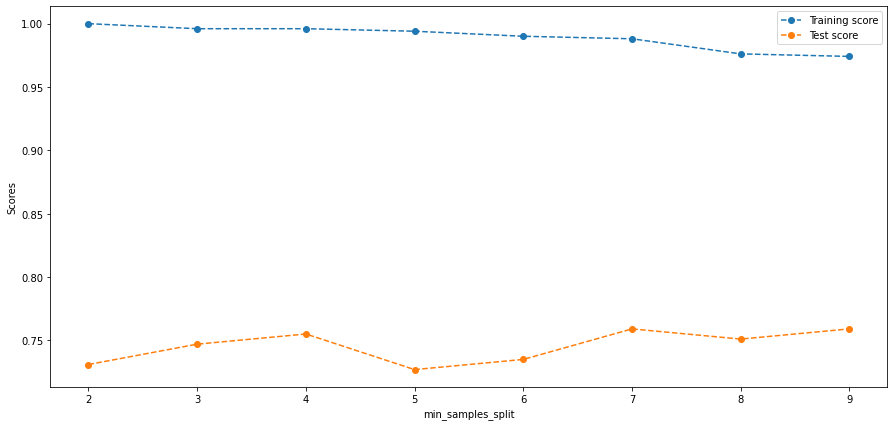

In [7]:
# 'min_samples_split'
TTest=[]
TTrain=[]

for k in range(2,10):
  Tree = DecisionTreeClassifier(min_samples_split=k)
  Tree.fit(X_train,y_train)
  # Score in the training set
  TTrain.append(Tree.score(X_train,y_train))
  # Score in the test set
  TTest.append(Tree.score(X_test,y_test))

print(TTest)
print(TTrain)

plt.figure(figsize=(15,7))
plt.plot(np.arange(2,10),TTrain,linestyle='--',marker='o',label="Training score")
plt.plot(np.arange(2,10),TTest,linestyle='--',marker='o',label='Test score')
plt.xlabel("min_samples_split")
plt.ylabel("Scores")
plt.legend()
plt.show()

[0.7309236947791165, 0.7309236947791165, 0.7309236947791165, 0.6987951807228916, 0.7590361445783133, 0.7630522088353414, 0.7469879518072289, 0.7791164658634538]
[1.0, 0.9960238568588469, 0.9960238568588469, 0.9940357852882704, 0.9880715705765407, 0.9860834990059643, 0.9761431411530815, 0.974155069582505]


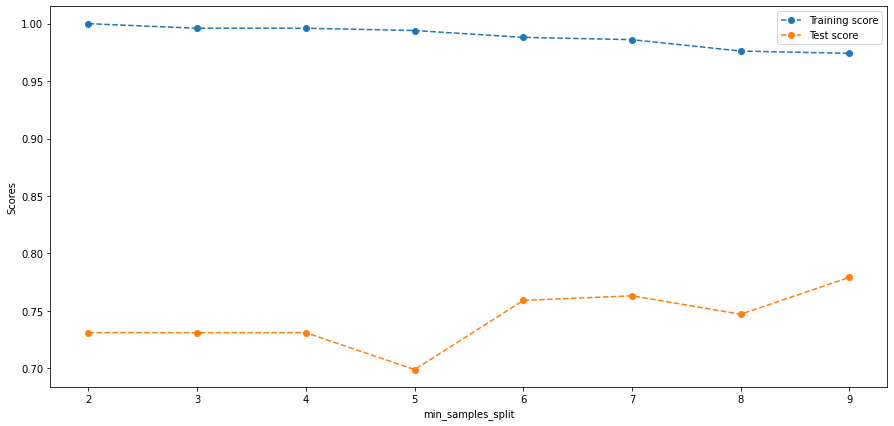

In [8]:
## We split differently our data 

X_train1, X_test1, y_train1, y_test1 = train_test_split(X_scale, np.ravel(y), test_size=0.33, random_state=42)

# 'min_samples_split'
TTest=[]
TTrain=[]

for k in range(2,10):
  Tree = DecisionTreeClassifier(min_samples_split=k)
  Tree.fit(X_train,y_train)
  # Score in the training set
  TTrain.append(Tree.score(X_train1,y_train1))
  # Score in the test set
  TTest.append(Tree.score(X_test1,y_test1))

print(TTest)
print(TTrain)

plt.figure(figsize=(15,7))
plt.plot(np.arange(2,10),TTrain,linestyle='--',marker='o',label="Training score")
plt.plot(np.arange(2,10),TTest,linestyle='--',marker='o',label='Test score')
plt.xlabel("min_samples_split")
plt.ylabel("Scores")
plt.legend()
plt.show()

[0.7228915662650602, 0.7228915662650602, 0.7349397590361446, 0.7389558232931727, 0.7309236947791165, 0.7429718875502008, 0.751004016064257, 0.7550200803212851]
[0.9701789264413518, 0.9582504970178927, 0.9403578528827038, 0.9264413518886679, 0.9244532803180915, 0.9085487077534792, 0.9085487077534792, 0.904572564612326]


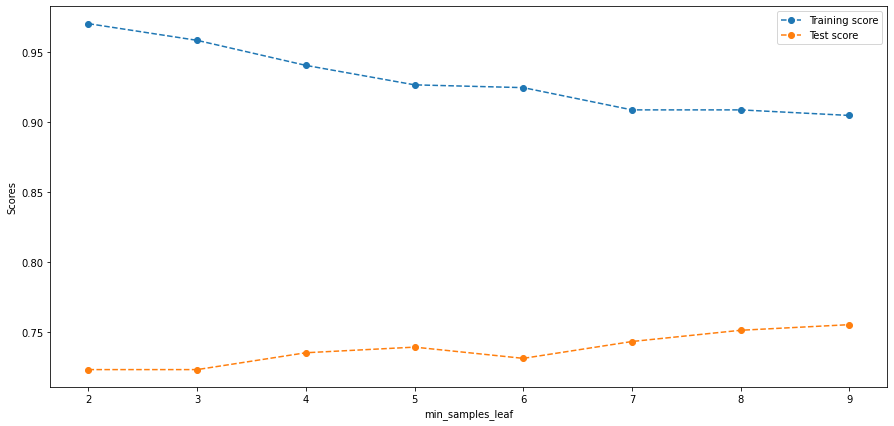

In [9]:
# 'min_samples_leaf'


TTest=[]
TTrain=[]

for k in range(2,10):
  Tree = DecisionTreeClassifier(min_samples_leaf=k)
  Tree.fit(X_train,y_train)
  # Score in the training set
  TTrain.append(Tree.score(X_train,y_train))
  # Score in the test set
  TTest.append(Tree.score(X_test,y_test))

print(TTest)
print(TTrain)

plt.figure(figsize=(15,7))
plt.plot(np.arange(2,10),TTrain,linestyle='--',marker='o',label="Training score")
plt.plot(np.arange(2,10),TTest,linestyle='--',marker='o',label='Test score')
plt.xlabel("min_samples_leaf")
plt.ylabel("Scores")
plt.legend()
plt.show()

[0.7389558232931727, 0.7269076305220884, 0.7269076305220884, 0.7349397590361446, 0.7349397590361446, 0.7429718875502008, 0.751004016064257, 0.7550200803212851]
[0.9701789264413518, 0.9622266401590457, 0.9403578528827038, 0.9304174950298211, 0.9264413518886679, 0.9085487077534792, 0.9085487077534792, 0.9025844930417495]


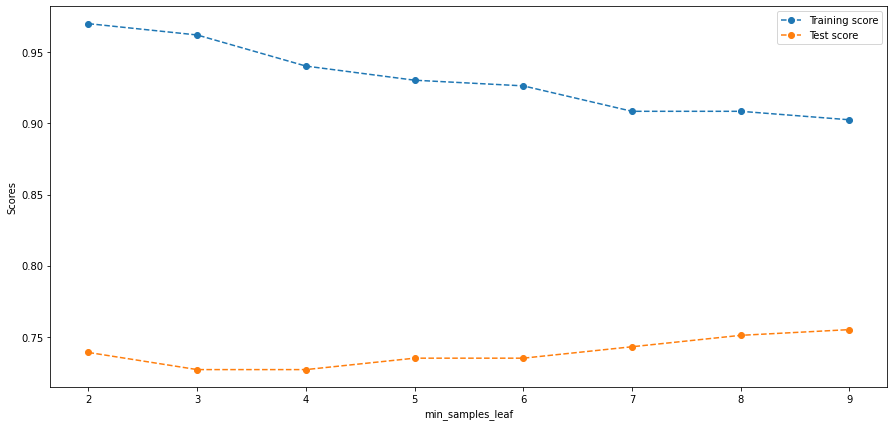

In [10]:
## We split differently our data 

X_train1, X_test1, y_train1, y_test1 = train_test_split(X_scale, np.ravel(y), test_size=0.33, random_state=42)

# 'min_samples_leaf'


TTest=[]
TTrain=[]

for k in range(2,10):
  Tree = DecisionTreeClassifier(min_samples_leaf=k)
  Tree.fit(X_train,y_train)
  # Score in the training set
  TTrain.append(Tree.score(X_train,y_train))
  # Score in the test set
  TTest.append(Tree.score(X_test,y_test))

print(TTest)
print(TTrain)

plt.figure(figsize=(15,7))
plt.plot(np.arange(2,10),TTrain,linestyle='--',marker='o',label="Training score")
plt.plot(np.arange(2,10),TTest,linestyle='--',marker='o',label='Test score')
plt.xlabel("min_samples_leaf")
plt.ylabel("Scores")
plt.legend()
plt.show()

---

**Response :** If we use min_samples_split, the best parameter is 9.
If we use min_samples_leaf, the best is 7. But if we split differently our data, this is different so it is not very significant.

---

Try to add Gaussian noise to the data (using for instance zero mean and 0.5 for the std) and, using the best hyperparameters found before, look at the test score. Repeat this process several times (at least 100 times) and compare the results with the score obtained without adding noise. **Question:** Are the results stable ? Hint: you could use for instance *noise = np.random.normal(mu, sigma)*

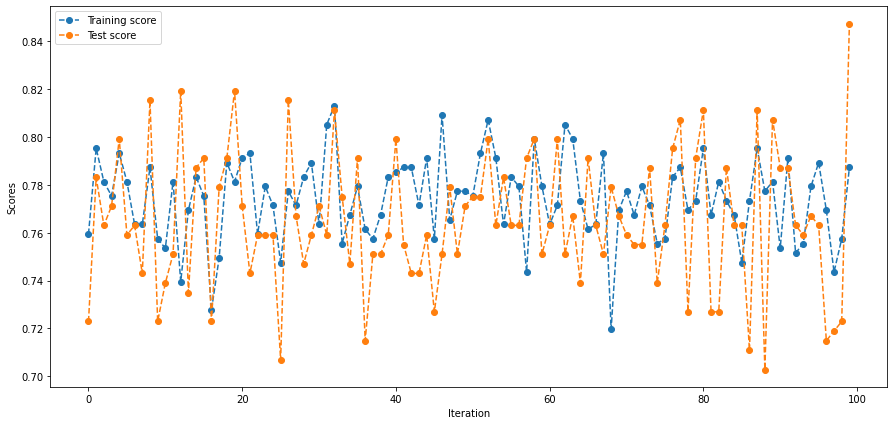

In [11]:
TTest=[]
TTrain=[]

for i in range(100):
  X_train_noise=[]
  for x in X_train:
    new_x=[]
    for xi in x:
      new_xi=xi+np.random.normal(0, 0.5)
      new_x.append(new_xi)
    X_train_noise.append(new_x)
  Tree = DecisionTreeClassifier(min_samples_split=9,min_samples_leaf=7)
  Tree.fit(X_train_noise,y_train)
  # Score in the training set
  TTrain.append(Tree.score(X_train,y_train))
  # Score in the test set
  TTest.append(Tree.score(X_test,y_test))

plt.figure(figsize=(15,7))
plt.plot(np.arange(0,100),TTrain,linestyle='--',marker='o',label="Training score")
plt.plot(np.arange(0,100),TTest,linestyle='--',marker='o',label='Test score')
plt.xlabel("Iteration")
plt.ylabel("Scores")
plt.legend()
plt.show()

--- 

***Response :*** When we add some noise, the training score and the test score vary a lot so we can say that the results are unstable. Decision trees have in fact  a very high variance.

---

To plot decision trees, we can also use the *graphviz* library. If you need to install it locally, you can do it using *conda install python-graphviz*. 
 

First plot the tree learnt on the original data, witout adding noise.

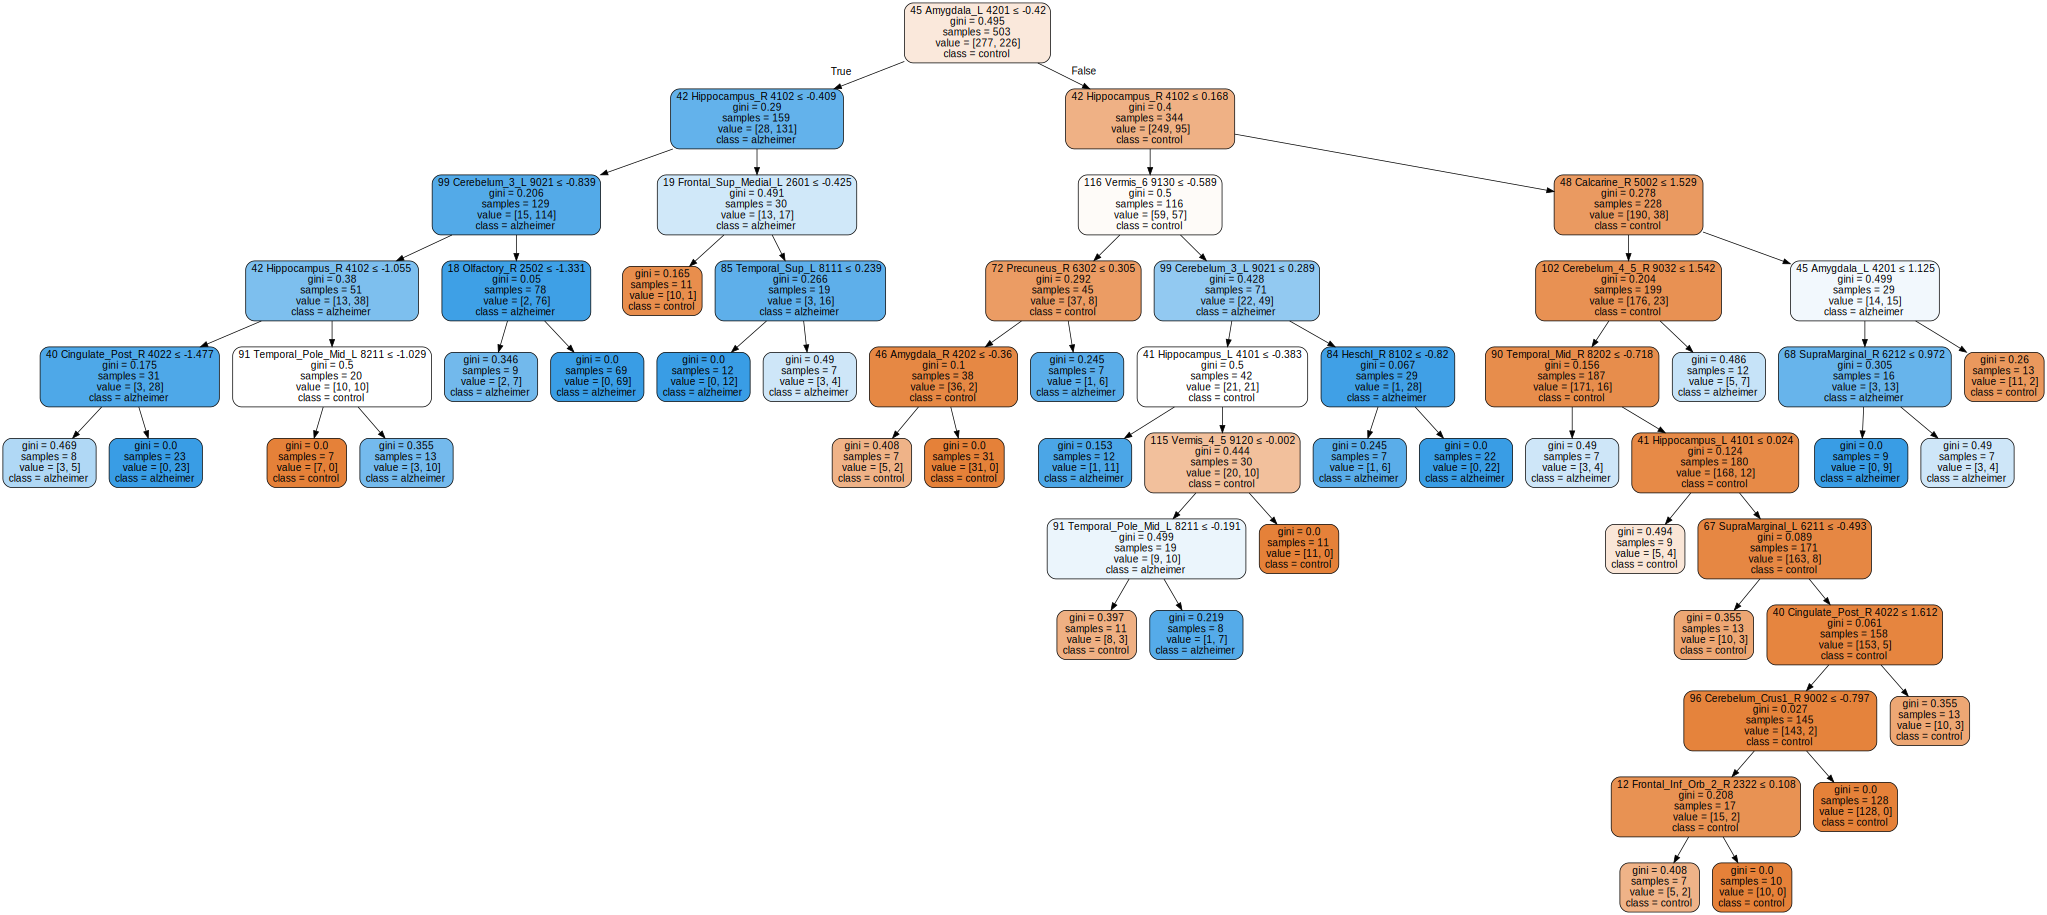

In [12]:
import graphviz 

Tree.fit(X_train,y_train)
dot_data = tree.export_graphviz(Tree, out_file=None,feature_names=labels,class_names=class_names,filled=True, rounded=True,special_characters=True)
graph = graphviz.Source(dot_data)
graph

Now, plot the tree learnt on noisy data. **Question:** Is it the same ? You can try several times, for different levels of noise. Comment the results.

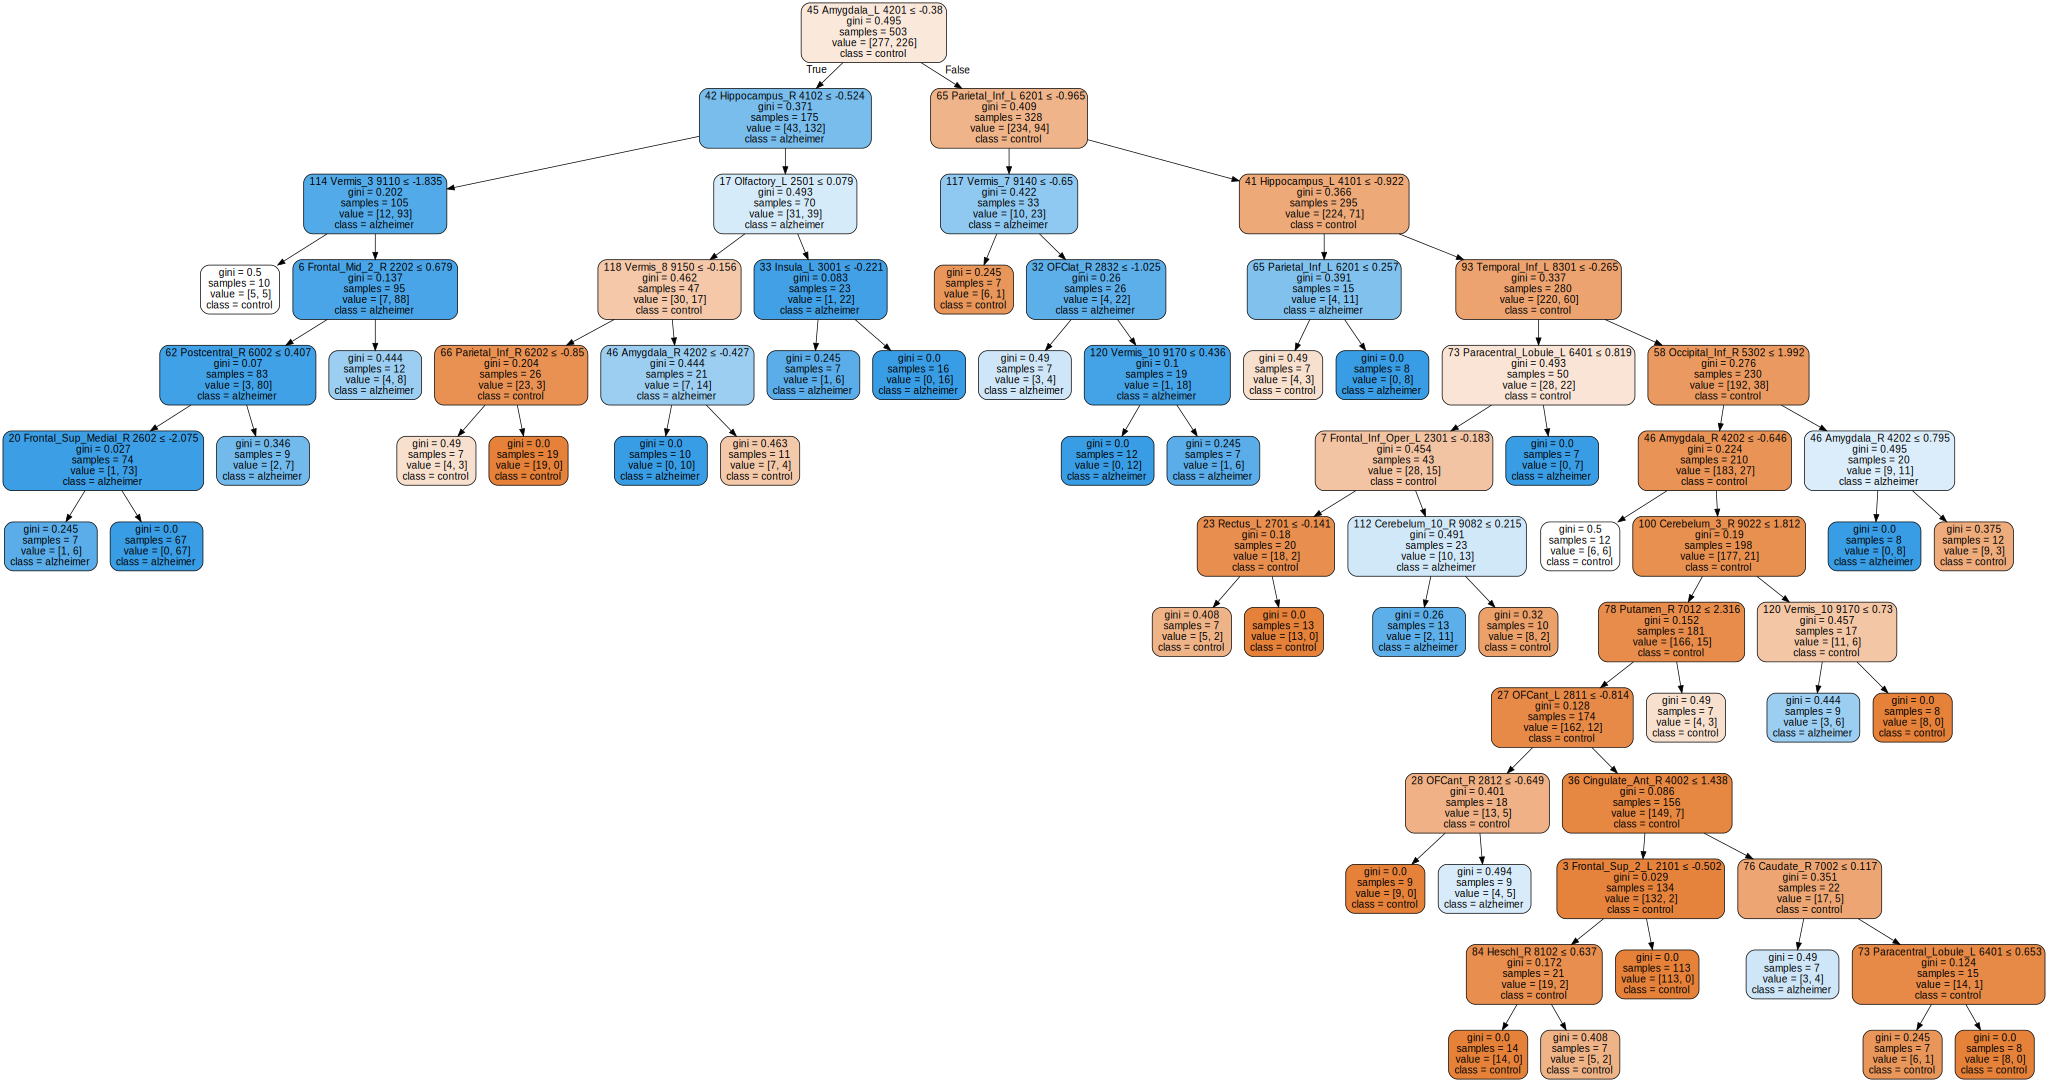

In [13]:
 #Withe the same noise

Tree.fit(X_train_noise,y_train)
dot_data = tree.export_graphviz(Tree, out_file=None,feature_names=labels,class_names=class_names,filled=True, rounded=True,special_characters=True)
graph = graphviz.Source(dot_data)
graph

---

***Response :*** The beginnig of the three is the same, but when we look at the nodes with a higher depth, they are different if we add some noise. Sometimes, even the root is different which proves that this technique is not robust.

---

Instead than using a single split of the data, we could also use Cross Validation to compute the best hyperparameter values for both 'min_samples_split' and 'min_samples_leaf' at the same time and in an automatic way. **Question:** Do you find the same optimal hyperparameters as before ? Hint: use GridSearchCV

In [14]:
from sklearn.model_selection import GridSearchCV

p_grid_tree = {'min_samples_split': [2,3,4,5,6,7,8,9,10],
              'min_samples_leaf': [2,3,4,5,6,7,8,9,10], }

Tree = DecisionTreeClassifier()

inner_cv = KFold(n_splits=5, shuffle=True, random_state=42)
outer_cv = KFold(n_splits=5, shuffle=True, random_state=42)
# Nested CV with parameter optimization
clf = GridSearchCV(estimator=Tree, param_grid=p_grid_tree, cv=inner_cv)
nested_score = cross_val_score(Tree, X_scale,y ,cv=outer_cv)


grid_tree= GridSearchCV(estimator=Tree, param_grid=p_grid_tree, cv=5)   
grid_tree.fit(X_train,y_train) 
print("Best Score: {}".format(grid_tree.best_score_))
print("Best params: {}".format(grid_tree.best_params_))

Best Score: 0.7595049504950495
Best params: {'min_samples_leaf': 6, 'min_samples_split': 2}


---

***Response :*** We don't have the same hyperparameters as before even if we didn't add noise, that proves the unstability of the model 

---

Using the optimal hyperparameers, plot again the decision tree using the *graphviz* library. **Question:** Is it the same ? Do you see ROIs that are always present nearby the root of the trees ? Comment the results.

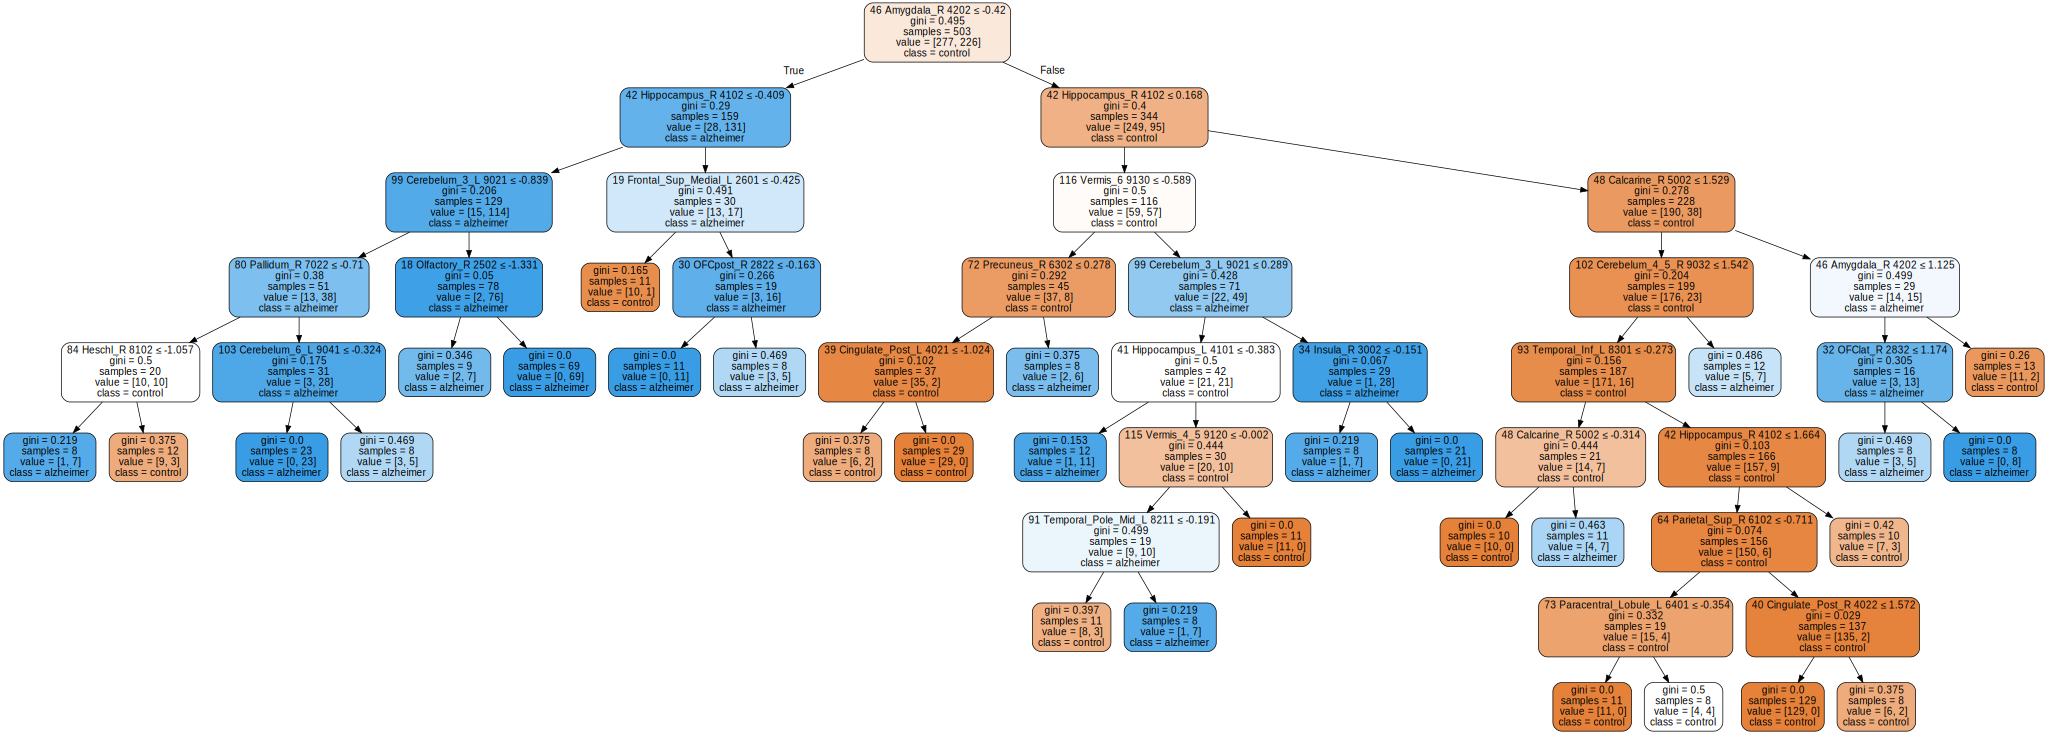

In [15]:
Tree = DecisionTreeClassifier(min_samples_split=2,min_samples_leaf=8)
Tree.fit(X_train,y_train)
dot_data = tree.export_graphviz(Tree, out_file=None,feature_names=labels,class_names=class_names,filled=True, rounded=True,special_characters=True)
graph = graphviz.Source(dot_data)
graph


--- 

***Response :*** It is not the same, but again we see that there are ROIS that are frequently nearby the roots, like 46 Amygdala or 42 Hippocampus.

---

Try to use now Bagging. You can use the following code where we use the previously computed best parameters 'min_samples_leaf' and 'min_samples_split'. **Question:** What happens when you use the original data and the noisy version ? Do you notice any difference in the prediction scores with respect to the results using Decision Trees ? 

In [17]:
from sklearn.ensemble import BaggingClassifier

Tree = DecisionTreeClassifier(criterion="gini",min_samples_leaf=8,min_samples_split=2, random_state=0)

p_grid_bagging = {'n_estimators': [5,10,15,20]}      
bag=BaggingClassifier(base_estimator=Tree, random_state=0)
grid_bagging = GridSearchCV(estimator=bag, param_grid=p_grid_bagging, scoring="accuracy", cv=5)
grid_bagging.fit(X_train, y_train)
print("Best Score (training) : {}".format(grid_bagging.best_score_))
print("Best params: {}".format(grid_bagging.best_params_))
print("Bagging score (test) :",grid_bagging.score(X_test,y_test))

Best Score (training) : 0.7954455445544555
Best params: {'n_estimators': 15}
Bagging score (test) : 0.8112449799196787


In [18]:
# Noisy version 

p_grid_bagging = {'n_estimators': [5,10,15,20]}      
bag=BaggingClassifier(base_estimator=Tree, random_state=0)
grid_bagging = GridSearchCV(estimator=bag, param_grid=p_grid_bagging, scoring="accuracy", cv=5)
grid_bagging.fit(X_train_noise, y_train)
print("Best Score (training) : {}".format(grid_bagging.best_score_))
print("Best params: {}".format(grid_bagging.best_params_))
print("Bagging score (test) :",grid_bagging.score(X_test,y_test))

Best Score (training) : 0.7555247524752475
Best params: {'n_estimators': 20}
Bagging score (test) : 0.8112449799196787


--- 

***Response :*** There isn't any huge difference into the scores so we can say that bagging is much more robust than simple trees. Also, the scores are better, and the test score is better than the training score whcih guarantees that there is no overfitting.

---

The last part of this TP is about Random Forests. We can estimate the three hyperparameters *'n_estimators'*, *'min_samples_leaf'* and *'max_features'*, the number of features to consider when looking for the best split, as before using Cross Validation

In [19]:
from sklearn.ensemble import RandomForestClassifier

RF=RandomForestClassifier(criterion="gini", random_state=0)
p_grid_RF = {'n_estimators': [10,15,20,25,30], 'min_samples_leaf': [2,3,4,5,6], 'max_features': ['sqrt','log2']}   

grid_RF = GridSearchCV(estimator=RF, param_grid=p_grid_RF, scoring="accuracy", cv=5)
grid_RF.fit(X_train, y_train)
print("Best Score: {}".format(grid_RF.best_score_))
print("Best params: {}".format(grid_RF.best_params_))

Best Score: 0.8170297029702971
Best params: {'max_features': 'sqrt', 'min_samples_leaf': 4, 'n_estimators': 30}


**Question:** Using the estimated best hyperparameters, test the performance of Random Forest on the noisy data and compare the results with Decision Trees and Bagging. 

In [20]:
RF=RandomForestClassifier(criterion="gini", random_state=0,max_features='sqrt',min_samples_leaf=4,n_estimators=30)
RF.fit(X_train_noise, y_train)

print("Training score with noise :",RF.score(X_train_noise,y_train))
print("Test score with noise :",RF.score(X_test,y_test))

print("-----------------------------------------------")

RF.fit(X_train, y_train)

print("Training score without noise :",RF.score(X_train_noise,y_train))
print("Test score without noise :",RF.score(X_test,y_test))

Training score with noise : 0.9801192842942346
Test score with noise : 0.8473895582329317
-----------------------------------------------
Training score without noise : 0.8369781312127237
Test score without noise : 0.8353413654618473


---

***Response :*** With bagging, the scores are higher than simple decision trees, and bagging is less sensitive to little changes in our data, more robust.

---

We can also use Random Forests to check the importance of the features

Feature ranking:
1. feature 45 representing 46 Amygdala_R 4202
 (0.073080)
2. feature 44 representing 45 Amygdala_L 4201
 (0.069032)
3. feature 41 representing 42 Hippocampus_R 4102
 (0.064159)
4. feature 40 representing 41 Hippocampus_L 4101
 (0.054429)
5. feature 43 representing 44 ParaHippocampal_R 4112
 (0.047404)
6. feature 93 representing 94 Temporal_Inf_R 8302
 (0.032653)
7. feature 92 representing 93 Temporal_Inf_L 8301
 (0.026649)
8. feature 88 representing 89 Temporal_Mid_L 8201
 (0.021777)
9. feature 86 representing 87 Temporal_Pole_Sup_L 8121
 (0.020273)
10. feature 59 representing 60 Fusiform_R 5402
 (0.018825)


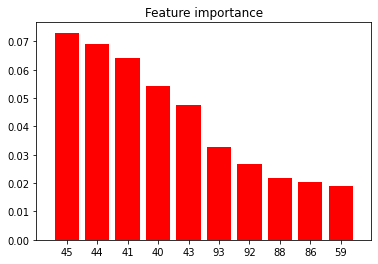

In [21]:
best_params=grid_RF.best_params_
RF = RandomForestClassifier(criterion="gini",min_samples_leaf=best_params["min_samples_leaf"],max_features=best_params["max_features"],n_estimators=best_params["n_estimators"], random_state=0)
RF.fit(X_train,y_train)

importances = RF.feature_importances_
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(10):
    print("%d. feature %d representing %s (%f)" % (f + 1, indices[f], labels[indices[f]], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importance")
plt.bar(range(10), importances[indices[0:10]], color="r", align="center")
plt.xticks(range(10), indices[0:10])
plt.xlim([-1, 10])
plt.show()

**Question:** Which are the most important features (i.e. ROIs) ?  Based on the two given research papers, you can verify if your results make sense. 

---

***Response :*** The most important features are Amygdala_R, Amygdala_L, Hippocampus_R and Hippocampus_L. These features make sense with the paper _A review on neuroimaging-based classification studies and associated
feature extraction methods for Alzheimer's disease and its prodromal stages_ where the hippocampus is said to be  "_amongst the few structures
of the medial temporal lobe that undergo severe structural changes in
AD_" and they also speak about amygdala.

In _The clinical use of structural MRI in Alzheimer disease_, these regions are also considered to be very important.

---

We can also inspect the data using only pairs of the most important features

Score = 0.8349900596421471
Score = 0.8608349900596421
Score = 0.8409542743538767
Score = 0.8608349900596421
Score = 0.8409542743538767
Score = 0.8588469184890656


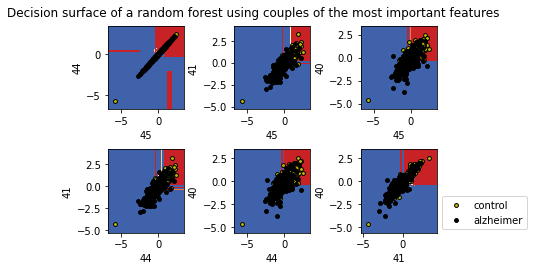

In [22]:
for pairidx, pair in enumerate([ [indices[0],indices[1]], [indices[0],indices[2]], [indices[0],indices[3]],
                                [indices[1],indices[2]], [indices[1],indices[3]], [indices[2],indices[3]] ]):
    # We only take the two corresponding features
    Xpair = X_train[:, pair]
    ypair = y_train

    # Train
    clf = RF.fit(Xpair, ypair)
    print("Score =", clf.score(Xpair, ypair))

    # Plot the decision boundary
    plt.subplot(2, 3, pairidx + 1)

    x_min, x_max = Xpair[:, 0].min() - 1, Xpair[:, 0].max() + 1
    y_min, y_max = Xpair[:, 1].min() - 1, Xpair[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                         np.arange(y_min, y_max, 0.02))
    plt.tight_layout(h_pad=0.5, w_pad=0.5, pad=2.5)

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    cs = plt.contourf(xx, yy, Z, cmap=plt.cm.RdYlBu)

    plt.xlabel(pair[0])
    plt.ylabel(pair[1])

    # Plot the training points
    for i, color in zip(range(2), "yk"):
        idx = np.where(ypair == i)
        plt.scatter(Xpair[idx, 0], Xpair[idx, 1], c=color, label=class_names[i],
                    cmap=plt.cm.RdYlBu, edgecolor='black', s=15)

plt.suptitle("Decision surface of a random forest using couples of the most important features")
plt.legend(bbox_to_anchor=(1, 0.5))
plt.axis("tight")
plt.show()

**Question:** Which is the best couple of features ?

---

***Response :*** The best couple is 41-44 even if some alzheimer are in the zone control. It is the one that best separates the two classes.
The score is the best among the 6 cases.

---

**Different Atlas**

Previously, we have used the AAL2 which defines a precise split of the brain into ROIs.
**Question:** What happens if you change Atlas ? Do you obtain the same results ? Can you find a subset of ROIs that you could define 'biomarkers' of the Alzheimer's disease ? Justify your answer and check whether it makes sense by using the two given research papers.

You can use the AICHA (http://www.gin.cnrs.fr/fr/outils/aicha/) and HAMMERS (https://brain-development.org/brain-atlases/adult-brain-atlases/) atlas.

Number of controls and Alzheimer patients is respectively: 416.0 and 336.0
Number of ROI is: 192
Feature ranking:
1. feature 144 representing 145	S_Parietooccipital-4	146
 (0.083940)
2. feature 170 representing 171	G_Fusiform-6	172
 (0.030623)
3. feature 189 representing 190	N_Thalamus-7	191
 (0.024521)
4. feature 172 representing 173	N_Amygdala-1	174
 (0.023260)
5. feature 173 representing 174	N_Caudate-1	175
 (0.022209)
6. feature 188 representing 189	N_Thalamus-6	190
 (0.021911)
7. feature 186 representing 187	N_Thalamus-4	188
 (0.016020)
8. feature 128 representing 129	G_Paracentral_Lobule-1	130
 (0.014824)
9. feature 145 representing 146	S_Parietooccipital-5	147
 (0.014514)
10. feature 171 representing 172	G_Fusiform-7	173
 (0.014137)


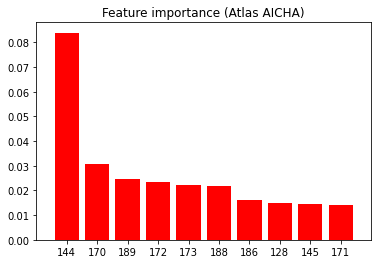

In [23]:
# Choose Atlas (here AICHA)
X=T1AICHA
labels=ROIlabelsAICHA
atlas='./AtlasAICHA.nii'

N,M = X.shape # number subjects and ROIs
class_names = ["control","alzheimer"] # y=0, y=1

print('Number of controls and Alzheimer patients is respectively: {0} and {1}'.format(N-np.sum(y), np.sum(y)))
print('Number of ROI is: {0}'.format(M))

# Scale data (each feature will have average equal to 0 and unit variance)

scaler = StandardScaler()
scaler.fit(X)
X_scale=scaler.transform(X)

# Create training and test set
X_train, X_test, y_train, y_test = train_test_split(X_scale, np.ravel(y), test_size=0.33, random_state=42)

best_params=grid_RF.best_params_
RF = RandomForestClassifier(criterion="gini",min_samples_leaf=best_params["min_samples_leaf"],max_features=best_params["max_features"],n_estimators=best_params["n_estimators"], random_state=0)
RF.fit(X_train,y_train)

importances = RF.feature_importances_
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(10):
    print("%d. feature %d representing %s (%f)" % (f + 1, indices[f], labels[indices[f]], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importance (Atlas AICHA)")
plt.bar(range(10), importances[indices[0:10]], color="r", align="center")
plt.xticks(range(10), indices[0:10])
plt.xlim([-1, 10])
plt.show()

Number of controls and Alzheimer patients is respectively: 416.0 and 336.0
Number of ROI is: 68
Feature ranking:
1. feature 3 representing Right Amygdala                         (0.117823)
2. feature 2 representing Left Amygdala                          (0.073434)
3. feature 0 representing Left Hippocampus                       (0.060795)
4. feature 46 representing Left Lateral Temporal Ventricle        (0.057031)
5. feature 1 representing Right Hippocampus                      (0.049371)
6. feature 47 representing Right Lateral Temporal Ventricle       (0.041278)
7. feature 12 representing Left Inferior Middle Temporal Gyri     (0.027861)
8. feature 8 representing Left Ambient and Parahippocampus Gyri  (0.024353)
9. feature 45 representing Right Corpus Callosum                  (0.020711)
10. feature 9 representing Right Ambient and Parahippocampus Gyri (0.018772)


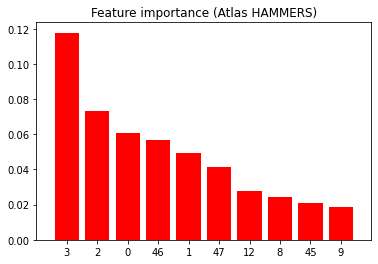

In [24]:
# Choose Atlas (here AICHA)
X=T1HAMMERS
labels=ROIlabelsHAMMERS
atlas='./AtlasHAMMERS.nii'

N,M = X.shape # number subjects and ROIs
class_names = ["control","alzheimer"] # y=0, y=1

print('Number of controls and Alzheimer patients is respectively: {0} and {1}'.format(N-np.sum(y), np.sum(y)))
print('Number of ROI is: {0}'.format(M))

# Scale data (each feature will have average equal to 0 and unit variance)

scaler = StandardScaler()
scaler.fit(X)
X_scale=scaler.transform(X)

# Create training and test set
X_train, X_test, y_train, y_test = train_test_split(X_scale, np.ravel(y), test_size=0.33, random_state=42)

best_params=grid_RF.best_params_
RF = RandomForestClassifier(criterion="gini",min_samples_leaf=best_params["min_samples_leaf"],max_features=best_params["max_features"],n_estimators=best_params["n_estimators"], random_state=0)
RF.fit(X_train,y_train)

importances = RF.feature_importances_
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(10):
    print("%d. feature %d representing %s (%f)" % (f + 1, indices[f], labels[indices[f]], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importance (Atlas HAMMERS)")
plt.bar(range(10), importances[indices[0:10]], color="r", align="center")
plt.xticks(range(10), indices[0:10])
plt.xlim([-1, 10])
plt.show()

---

***Response :*** The atlas HAMMERS and the research papers confirm that the amygdal and the hippocampus are very important. 
The amygdala is in the top ranking of the three atlas so we can say that it's the most important feature to examine. 

---

**Theoretical Questions**

**Question:** Please answer the two questions at slide 28 and 31 writing here the computations.

In [25]:
def h_ent(p1):
  if p1==1 or p1==0:
    return 0
  return -p1*np.log(p1)-(1-p1)*np.log(1-p1)

def h_gini(p1):
  return 2*p1*(1-p1)

print("Assessing the first split :")

ng=1.0
nd=1.0

L_ent=(ng)/(ng+nd)*h_ent(0.25)+(nd)/(ng+nd)*h_ent(0.25)
L_gini=(ng)/(ng+nd)*h_gini(0.25)+(nd)/(ng+nd)*h_gini(0.25)

print("The cost with entropy and gini are", L_ent, "and", L_gini)


print("----------------------------------------")
print("Assessing the second split :")

ng=3.0
nd=1.0

L_ent=(ng)/(ng+nd)*h_ent(1/3)+(nd)/(ng+nd)*h_ent(1)
L_gini=(ng)/(ng+nd)*h_gini(1/3)+(nd)/(ng+nd)*h_gini(1)

print("The cost with entropy and gini are", L_ent, "and", L_gini)

Assessing the first split :
The cost with entropy and gini are 0.5623351446188083 and 0.375
----------------------------------------
Assessing the second split :
The cost with entropy and gini are 0.4773856262211096 and 0.33333333333333337


---

***Response :*** We can see that the best split is definitely the second one, with both function H.

---